In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from scipy.optimize import curve_fit
from scipy.signal import spectrogram
import matplotlib.dates as mdates
from scipy.fft import fftshift
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [173]:
# Upload datasets
datasets = {}
datasets["oil"] = pd.read_csv("data/oil.csv")
datasets["stores"] = pd.read_csv("data/stores.csv")
datasets["train"] = pd.read_csv("data/train.csv")
datasets["test"] = pd.read_csv("data/test.csv")
datasets["transactions"] = pd.read_csv("data/transactions.csv")
datasets["holidays"] = pd.read_csv("data/holidays_events.csv")

In [174]:
# Transform rows to datetime
for _, dataset in datasets.items():
    if "date" in dataset.columns:
        dataset["date"] = pd.to_datetime(dataset["date"])

In [175]:
family = "GROCERY I"
sales_per_day = datasets["train"][datasets["train"]["family"] == family].groupby(datasets["train"]['date'].dt.date).sum()["sales"]

sales_per_day



date
2013-01-01       700.000
2013-01-02    202020.000
2013-01-03    144878.000
2013-01-04    135754.000
2013-01-05    188356.000
                 ...    
2017-08-11    238221.922
2017-08-12    238627.633
2017-08-13    258442.452
2017-08-14    225355.694
2017-08-15    224208.125
Name: sales, Length: 1684, dtype: float64

### Autocorrelation

In [176]:
#x = pd.plotting.autocorrelation_plot(sales_per_day.values)
#x.plot()

In [177]:
adfuller(sales_per_day.values)

(-3.448762638791253,
 0.00940471087835237,
 25,
 1658,
 {'1%': -3.434300212992577,
  '5%': -2.863284793874921,
  '10%': -2.567698886736967},
 39138.360502681644)

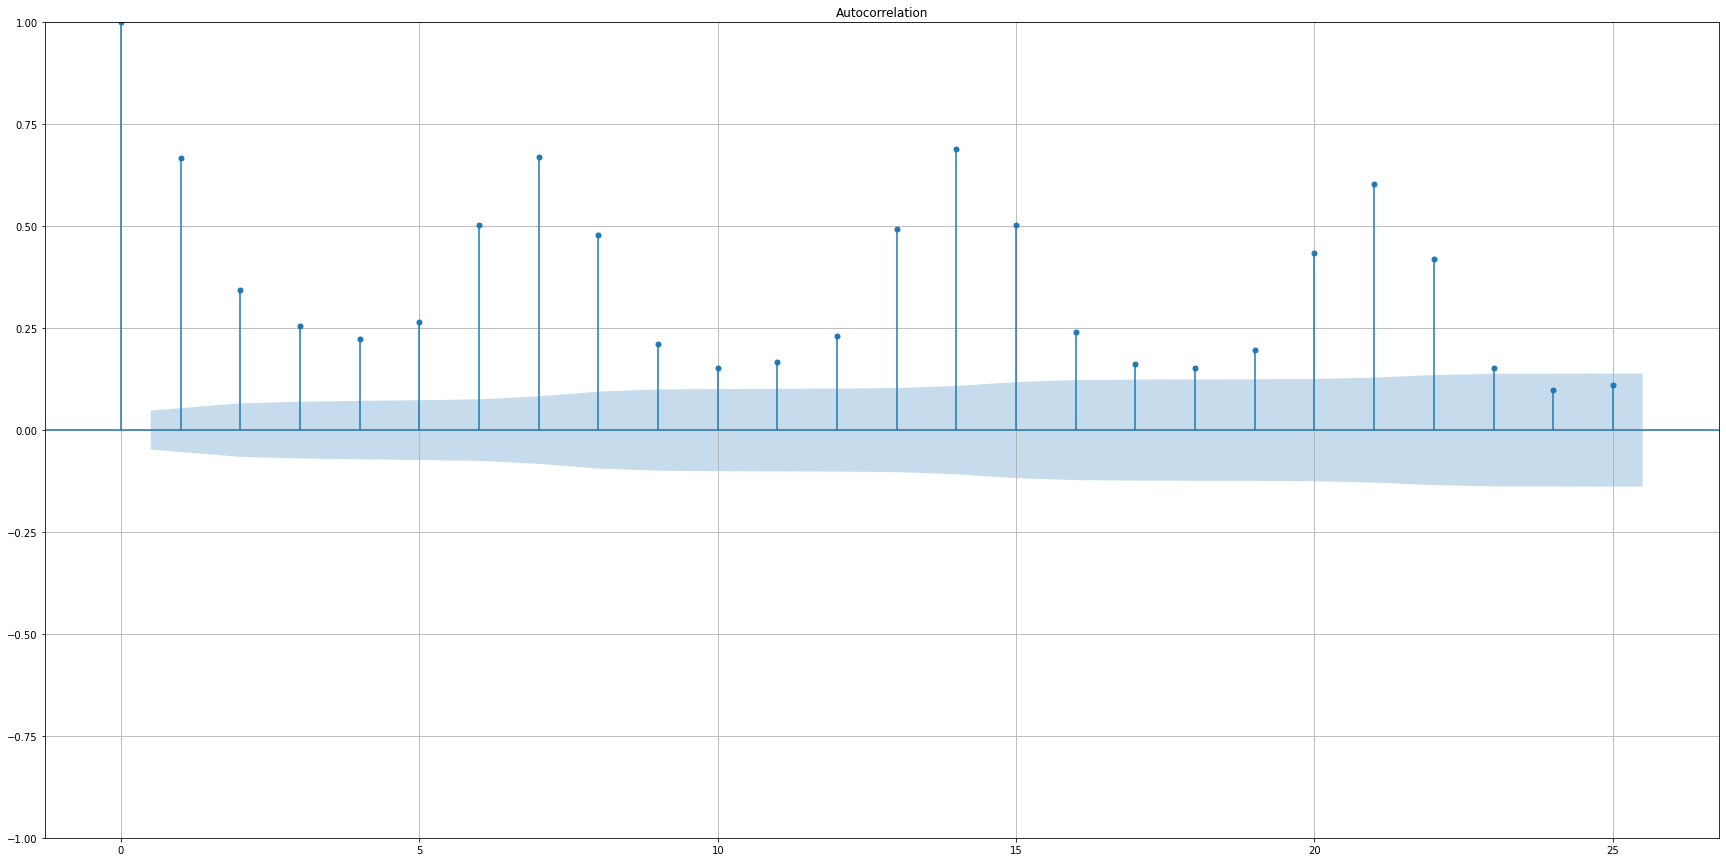

In [200]:
plot_acf(sales_per_day.values, lags=25)
plt.grid()
plt.show()

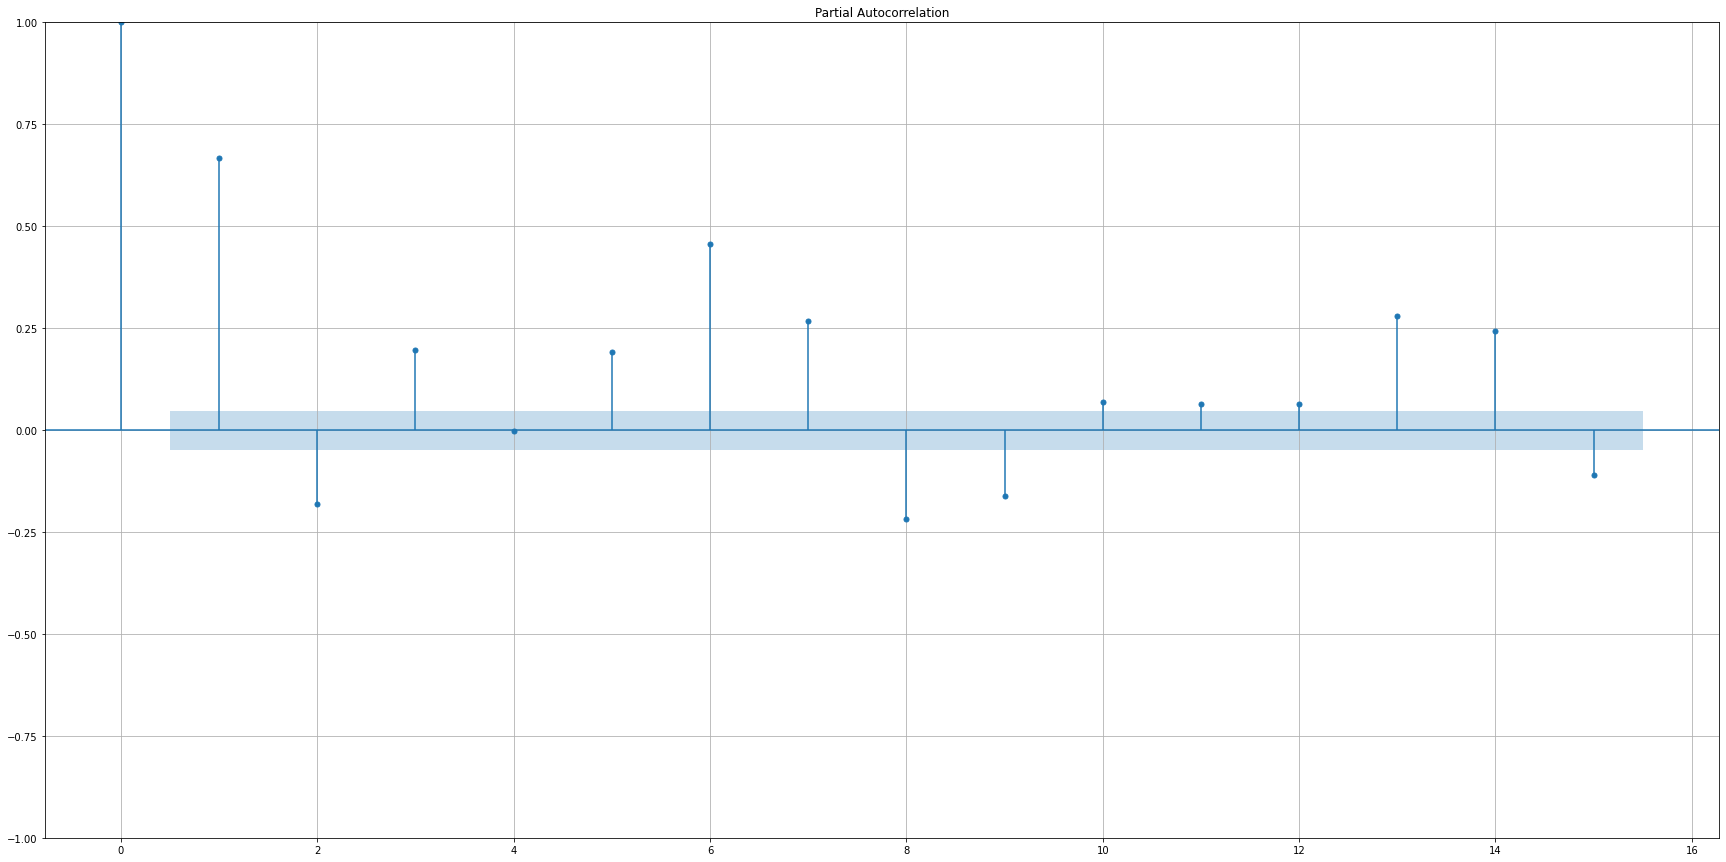

In [194]:
plot_pacf(sales_per_day.values, lags=15, method="ywm")
plt.grid()
plt.show()

### Additive descomposition

<Figure size 1440x4320 with 0 Axes>

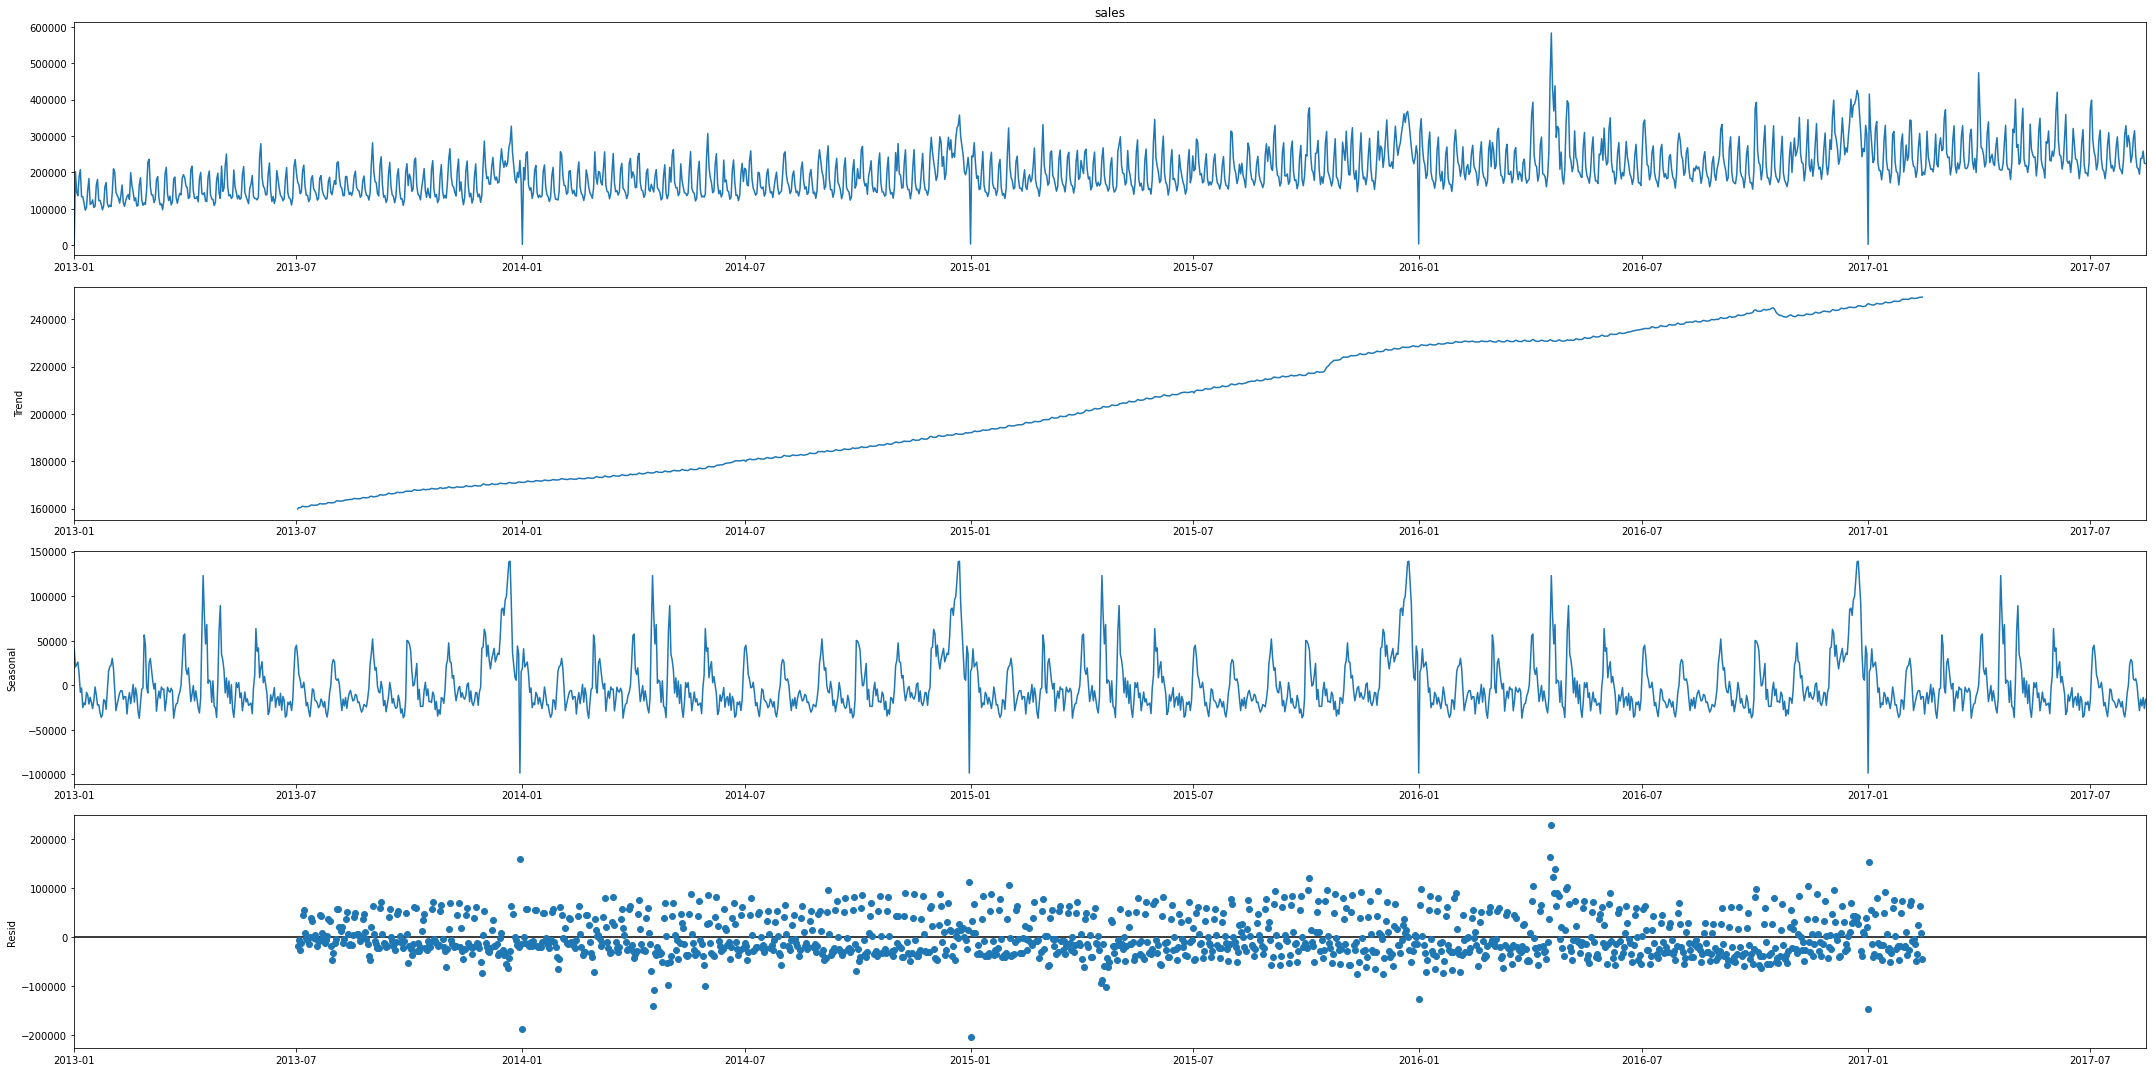

<Figure size 1440x4320 with 0 Axes>

In [180]:
result = seasonal_decompose(sales_per_day, model='additive', period=365)
 
rcParams['figure.figsize'] = 30, 15
result.plot()
plt.figure(figsize=(20, 60))

### Multiplicative descomposition

<Figure size 1440x4320 with 0 Axes>

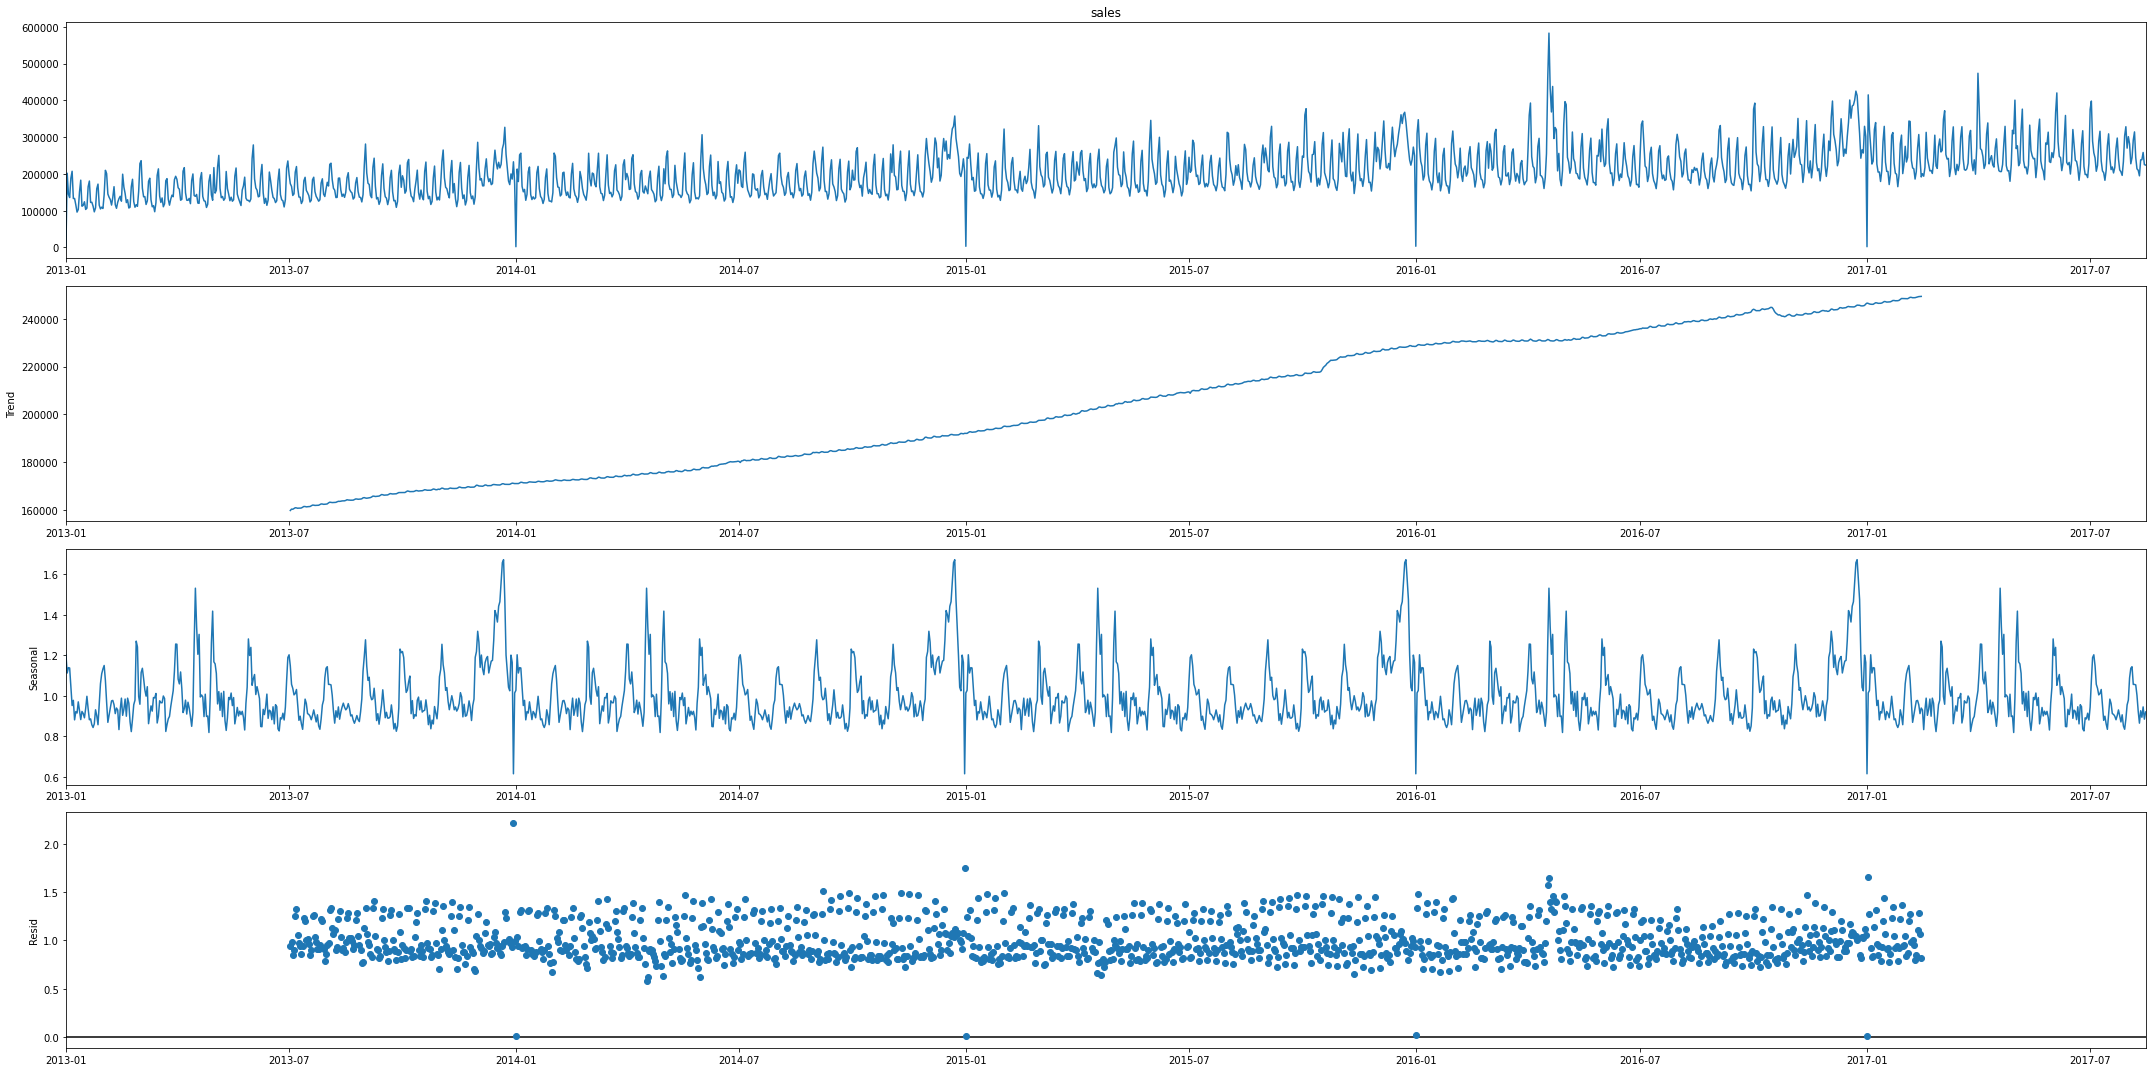

<Figure size 1440x4320 with 0 Axes>

In [181]:
result = seasonal_decompose(sales_per_day, model='multiplicative', period=365)
 
rcParams['figure.figsize'] = 30, 15
result.plot()
plt.figure(figsize=(20, 60))

### Trend

In [182]:

def plot_trend(series, model="linear"):

    if model == "cuadratic":
        def objective(x, a, b, c):
            return a * x + b * x ** 2 + c
    else:
        def objective(x, a, b):
            return a * x + b

    x = mdates.date2num(series.index)
    y = series.values

    popt, _ = curve_fit(objective, x, y)
    print(f"Model coefficients {popt}")

    x_line = np.arange(min(x), max(x), 1)
    y_line = objective(x_line, *popt)

    plt.figure(figsize=(20, 10))
    plt.grid()
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.plot(x_line, y_line)
    plt.plot(x, y)


    

Model coefficients [ 7.13101681e+01 -9.76180589e+05]


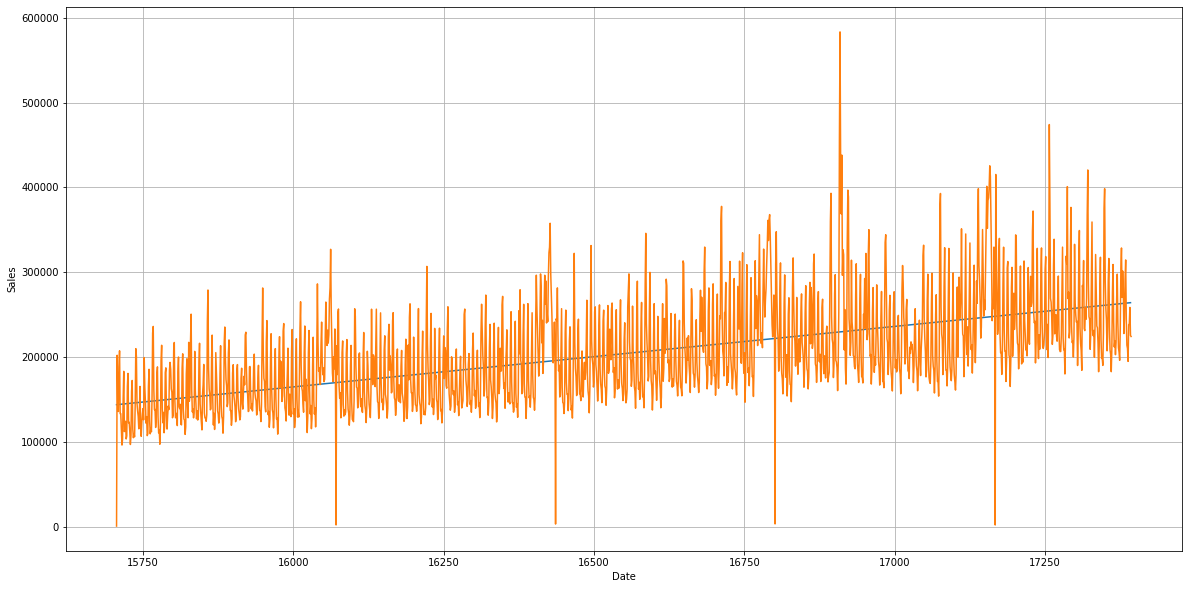

In [183]:
plot_trend(sales_per_day)

Model coefficients [ 1.93882411e+02 -3.70321948e-03 -1.98955025e+06]


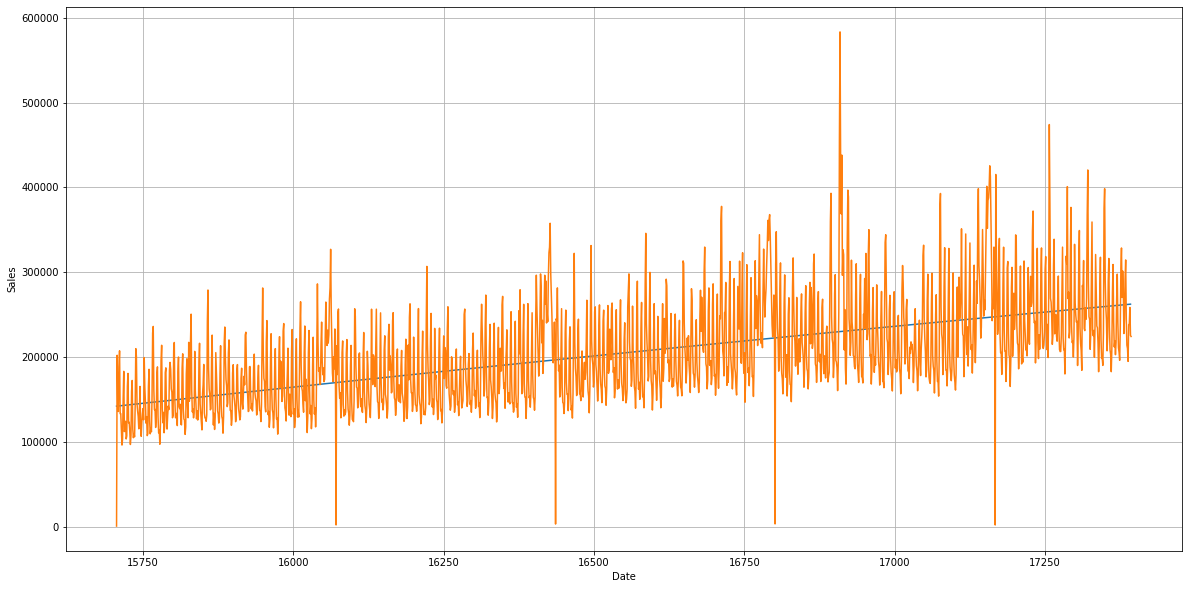

In [184]:
plot_trend(sales_per_day, model="cuadratic")

### Cycle

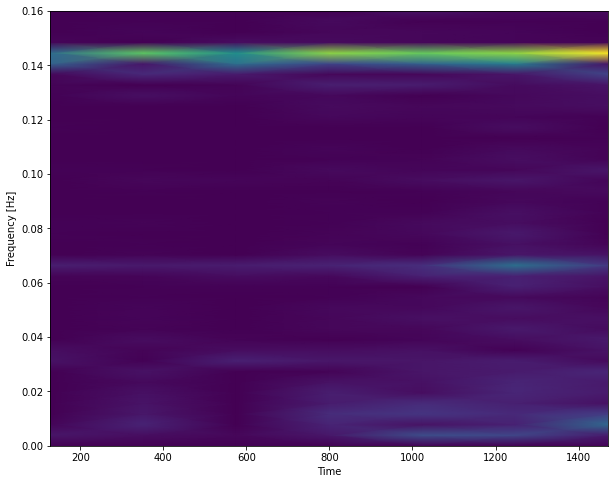

In [185]:
#<plt.plot(spectrogram(sales_per_day.values))
f, t, Sxx = spectrogram(sales_per_day.values)

plt.figure(figsize=(10, 8))
plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time')
plt.ylim([0, 0.16])
plt.show()

It is possible to see that there is a cycle every 1 week

In [186]:
#plt.figure(figsize=(10, 8))
#powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(sales_per_day.values, Fs=1, cmap="rainbow")

### ARIMA

In [201]:
d = 0 # No differenciation needed since time series is already stationary
q = 23
p = 3
arima = ARIMA(sales_per_day.values, order=(p, d, q))
arima_res = arima.fit()
print(arima_res.summary())

c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1684
Model:                ARIMA(3, 0, 23)   Log Likelihood              -19993.539
Date:                Thu, 26 May 2022   AIC                          40043.077
Time:                        21:05:05   BIC                          40195.087
Sample:                             0   HQIC                         40099.379
                               - 1684                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.04e+05   6699.987     30.441      0.000    1.91e+05    2.17e+05
ar.L1          0.4402      0.908      0.485      0.628      -1.339       2.219
ar.L2          0.0002      1.127      0.000      1.0

<AxesSubplot:>

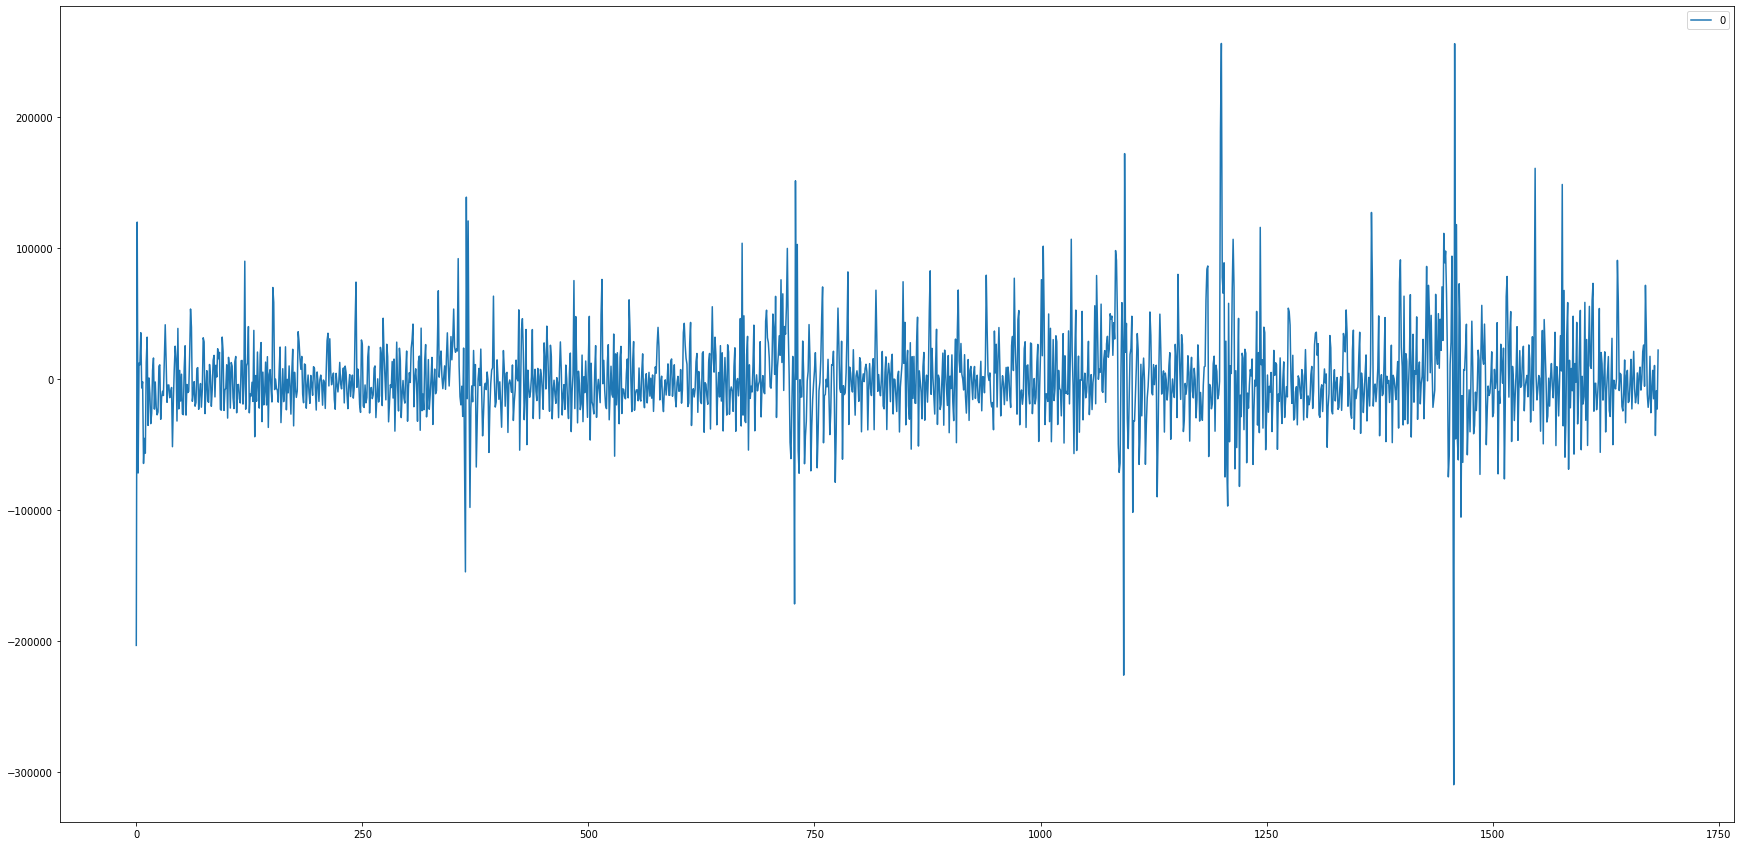

In [196]:
residuals = pd.DataFrame(arima_res.resid)
residuals.plot()


In [197]:
residuals.describe()

,0
count,1684.000000
mean,950.691255
std,34533.894304
min,-309598.659634
25%,-16967.040493
50%,-1600.039251
75%,16154.792491
max,256069.258453


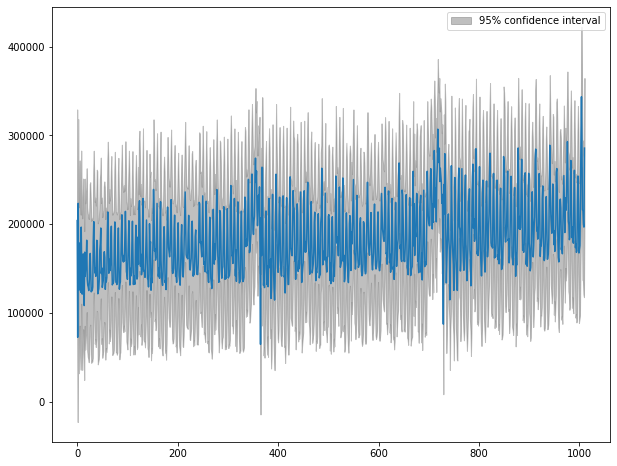

In [202]:
N = 1000
l = 10
fig, ax = plt.subplots(figsize=(10, 8))
plot_predict(arima_res, start=0, end=N + l, ax=ax)
plt.show()